In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [34]:
df=pd.read_csv("test.csv")
df.tail()

,time,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
59,21-Aug-23,19320.65,19425.95,19296.3,19393.60,262589133.0,20738.75
60,22-Aug-23,19417.10,19443.50,19381.3,19396.45,208704354.0,20226.48
61,23-Aug-23,19439.20,19472.05,19366.6,19444.00,225214991.0,20167.16
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df.columns = df.columns.str.strip()
df['time'] = pd.to_datetime(df['time'])  # Convert 'time' column to datetime type


In [36]:
df = df.dropna()
print(df['Close'].isnull().sum())


0


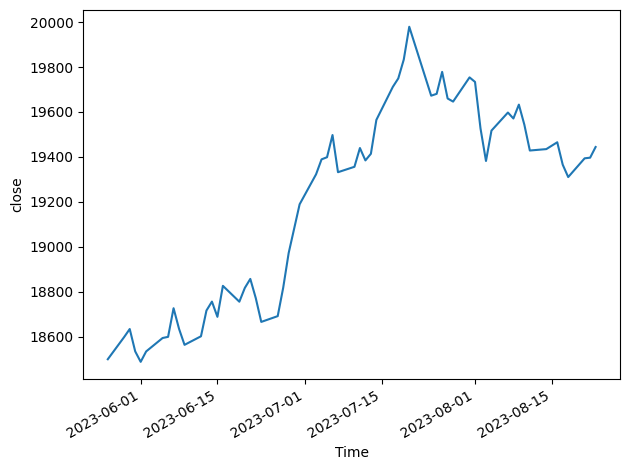

In [37]:
fig, ax = plt.subplots()

ax.plot(df.time, df['Close'])
ax.set_xlabel('Time')
ax.set_ylabel('close')


fig.autofmt_xdate()
plt.tight_layout()



In [38]:
ad_fuller_result=adfuller(df['Close'])
print(f'adf fuller:{ad_fuller_result[0]}')
print(f'p value:{ad_fuller_result[1]}')


adf fuller:-1.5002577643664798
p value:0.533383822711605


In [39]:
diff_df=np.diff(df['Close'],n=1)

ad_fuller_result = adfuller(diff_df)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.7849986778453735
p-value: 0.003064581747323089


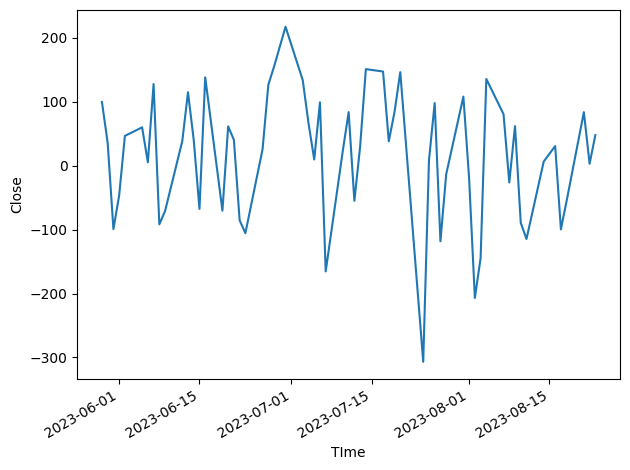

In [40]:
fig, ax = plt.subplots()

ax.plot(df['time'][1:], diff_df)
ax.set_xlabel('TIme')
ax.set_ylabel('Close')



fig.autofmt_xdate()
plt.tight_layout()

In [41]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [42]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [57]:
train = df['Close'][:-20]

result_df = optimize_ARIMA(train, order_list, d)
result_df

100%|██████████| 16/16 [00:00<00:00, 23.75it/s]


,"(p,q)",AIC
0,"(0, 0)",489.002992
1,"(2, 3)",489.617900
2,"(1, 0)",489.909020
3,"(0, 1)",489.935202
4,"(3, 2)",490.075832
5,"(3, 3)",491.279742
6,"(2, 2)",491.342320
7,"(1, 1)",491.890766
8,"(2, 0)",491.898774
9,"(0, 2)",491.929435


In [59]:
model = SARIMAX(train, order=(2,3,1), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   41
Model:               SARIMAX(2, 3, 1)   Log Likelihood                -244.845
Date:                Tue, 29 Aug 2023   AIC                            497.690
Time:                        02:08:54   BIC                            504.241
Sample:                             0   HQIC                           500.021
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4200      0.129     -3.259      0.001      -0.673      -0.167
ar.L2         -0.2511      0.145     -1.730      0.084      -0.536       0.033
ma.L1         -0.9984      5.976     -0.167      0.8

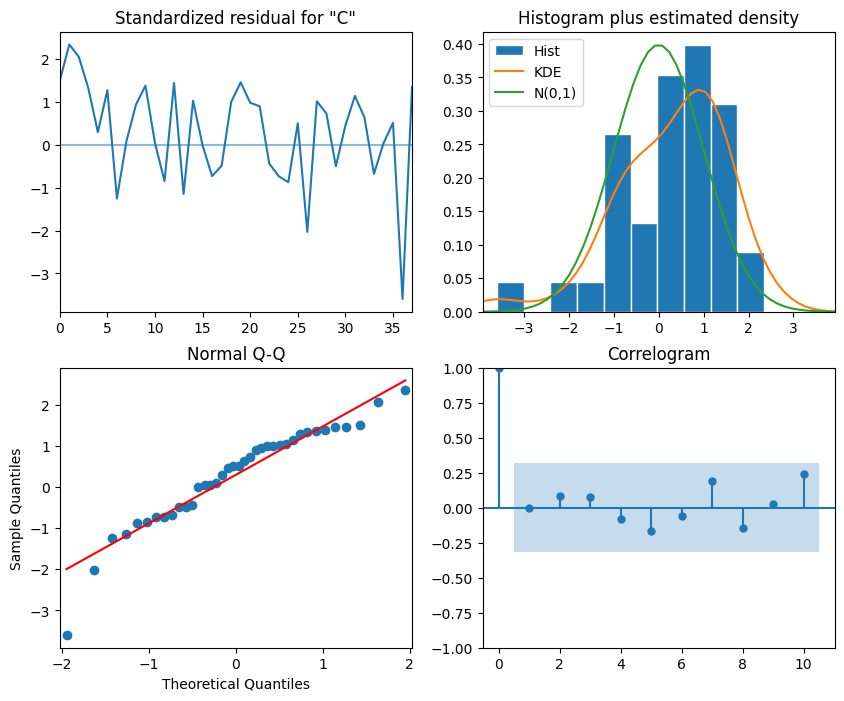

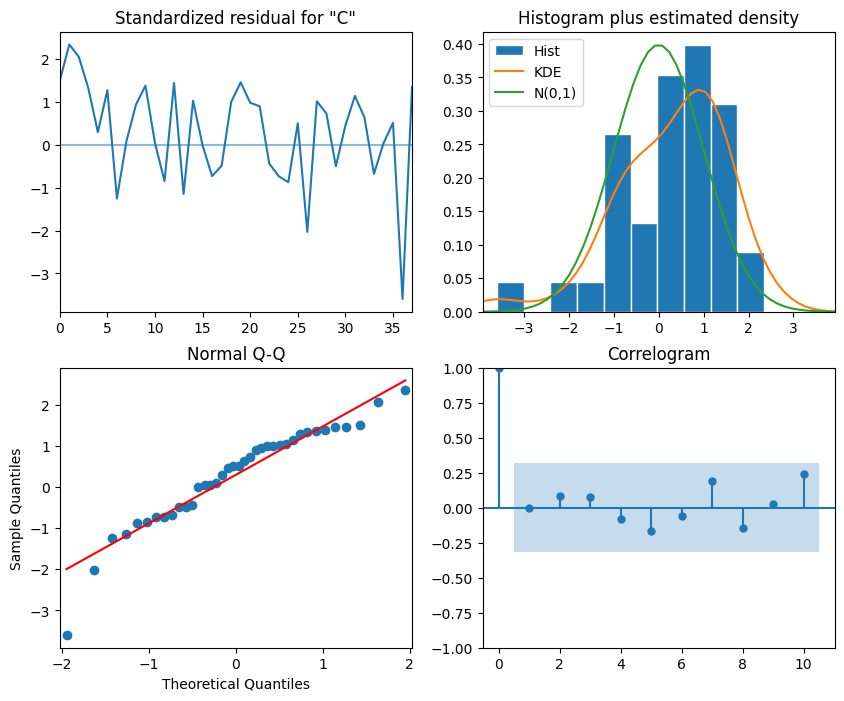

In [60]:
model_fit.plot_diagnostics(figsize=(10,8))

In [46]:
residuals = model_fit.resid
pvalue=[]
pvalue = acorr_ljungbox(residuals, lags=None)

print(pvalue)

    lb_stat  lb_pvalue
1  5.199589   0.022592
2  5.199811   0.074281
3  5.201673   0.157611
4  5.202325   0.267160
5  5.202330   0.391690
6  5.202335   0.518137


In [61]:
import pandas as pd

# Assuming 'df' is your DataFrame containing the data
df['time'] = pd.to_datetime(df['time'])

# Sort the DataFrame based on the 'time' column
df = df.sort_values('time')

# Now you can use .iloc[-30:] to select the last 30 rows
test = df.iloc[-20:]



test['naive_seasonal'] = df['Close'].iloc[-40:-20].values
test

,time,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr),naive_seasonal
42,2023-07-26,19733.35,19825.60,19716.70,19778.30,244747425.0,23023.86,18691.20
43,2023-07-27,19850.90,19867.55,19603.55,19659.90,334891351.0,35019.13,18817.40
44,2023-07-28,19659.75,19695.90,19563.10,19646.05,258671382.0,22995.98,18972.10
45,2023-07-31,19666.35,19772.75,19597.60,19753.80,295053318.0,23075.38,19189.05
46,2023-08-01,19784.00,19795.60,19704.60,19733.55,298048161.0,24554.71,19322.55
47,2023-08-02,19655.40,19678.25,19423.55,19526.55,290666798.0,23997.47,19389.00
48,2023-08-03,19463.75,19537.65,19296.45,19381.65,315688612.0,29899.38,19398.50
49,2023-08-04,19462.80,19538.85,19436.45,19517.00,280799561.0,28086.15,19497.30
50,2023-08-07,19576.85,19620.45,19524.80,19597.30,216586074.0,21655.87,19331.80
51,2023-08-08,19627.20,19634.40,19533.10,19570.85,260294052.0,25437.47,19355.90


In [62]:
ARIMA_pred = model_fit.get_prediction(31, 61).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,time,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr),naive_seasonal,ARIMA_pred
42,2023-07-26,19733.35,19825.60,19716.70,19778.30,244747425.0,23023.86,18691.20,19561.233375
43,2023-07-27,19850.90,19867.55,19603.55,19659.90,334891351.0,35019.13,18817.40,19492.105586
44,2023-07-28,19659.75,19695.90,19563.10,19646.05,258671382.0,22995.98,18972.10,19419.537823
45,2023-07-31,19666.35,19772.75,19597.60,19753.80,295053318.0,23075.38,19189.05,19330.473589
46,2023-08-01,19784.00,19795.60,19704.60,19733.55,298048161.0,24554.71,19322.55,19238.612493
47,2023-08-02,19655.40,19678.25,19423.55,19526.55,290666798.0,23997.47,19389.00,19141.478899
48,2023-08-03,19463.75,19537.65,19296.45,19381.65,315688612.0,29899.38,19398.50,19036.672341
49,2023-08-04,19462.80,19538.85,19436.45,19517.00,280799561.0,28086.15,19497.30,18925.822828
50,2023-08-07,19576.85,19620.45,19524.80,19597.30,216586074.0,21655.87,19331.80,18808.848504
51,2023-08-08,19627.20,19634.40,19533.10,19570.85,260294052.0,25437.47,19355.90,18685.374410


In [63]:
import matplotlib.dates as mdates

# Assuming 'time' column is in datetime format
date_format = mdates.DateFormatter('%Y-%m-%d')  # Use a format that matches your data
ax.xaxis.set_major_formatter(date_format)


In [64]:
df['time'] = pd.to_datetime(df['time'])


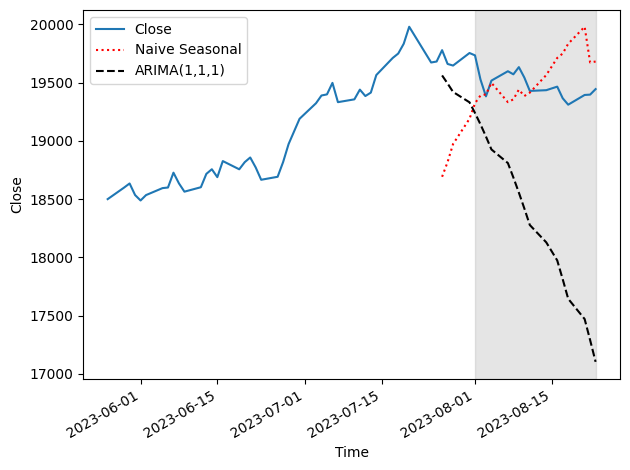

In [65]:
fig, ax = plt.subplots()

ax.plot(df['time'], df['Close'], label='Close')
ax.plot(test['time'], test['naive_seasonal'], 'r:', label='Naive Seasonal')
ax.plot(test['time'], test['ARIMA_pred'], 'k--', label='ARIMA(1,1,1)')

ax.set_xlabel('Time')
ax.set_ylabel('Close')
ax.axvspan(pd.Timestamp('2023-08-01'), pd.Timestamp('2023-08-23'), color='#808080', alpha=0.2)

ax.legend(loc='upper left')
fig.autofmt_xdate()
plt.tight_layout()

plt.show()


In [52]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [53]:
mape_naive_seasonal = mape(test['Close'], test['naive_seasonal'])
mape_ARIMA = mape(test['Close'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

3.7537693324100716 2.326733427907106


In [54]:
last_date = df['time'].max()

# Generate future dates for the next 'n' days
n = 10  # Number of days into the future you want to predict
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=n)

In [55]:
forecast_steps = 10  # Number of steps into the future you want to forecast

forecast = model_fit.get_forecast(steps=forecast_steps)
future_index = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=forecast_steps)

forecasted_mean = forecast.predicted_mean


In [56]:
future_data = pd.DataFrame({
    'time': future_index,
    'ARIMA_pred': forecasted_mean
})

# Append future_data to your original DataFrame
future_data


,time,ARIMA_pred
31,2023-08-24,19370.307144
32,2023-08-25,19431.431696
33,2023-08-26,19475.804605
34,2023-08-27,19518.837970
35,2023-08-28,19553.438333
36,2023-08-29,19588.186209
37,2023-08-30,19622.832864
38,2023-08-31,19658.782114
39,2023-09-01,19695.079172
40,2023-09-02,19731.547059
